*0. Dependencies installation*

In [1]:
!pip install deep-translator scikit-learn
!pip install pandas tiktoken huggingface_hub streamlit nltk matplotlib seaborn tensorflow keras


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


*1. Text Translation*
This cell uses the deep_translator library to translate text from English to Russian. The translate_text function performs the translation of the provided text into the target language, and the result is printed to verify its correctness.

In [2]:
from deep_translator import GoogleTranslator

def translate_text(text, target_language='ru'):
    translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
    return translated_text

translated_text = translate_text("Hello, how are you?", 'ru')
print(translated_text)

Привет, как дела?


*2. Inspecting JSONL Files*
The inspect_jsonl function reads the first few lines from a JSONL file and loads them into a list of dictionaries. This step helps in reviewing the structure and content of the data before further processing.

In [3]:
import json

def inspect_jsonl(file_path, num_lines=1):
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i < num_lines:
                data.append(json.loads(line))
            else:
                break
    return data

sample_data = inspect_jsonl('data/train.jsonl', num_lines=1)
print(json.dumps(sample_data, indent=2, ensure_ascii=False))

[
  {
    "phase": 1,
    "table_id": "1-1000181-1",
    "question": "Tell me what the notes are for South Australia ",
    "sql": {
      "sel": 5,
      "conds": [
        [
          3,
          0,
          "SOUTH AUSTRALIA"
        ]
      ],
      "agg": 0
    }
  }
]


*3. Loading, Translating, and Saving WikiSQL Data*
The load_wikisql_data function loads data from a JSONL file. Then, the data is translated into Russian, and the results are saved into a DataFrame. This is an essential step for preparing the data for model training.

In [4]:
import json
from tqdm import tqdm
import pandas as pd
from deep_translator import GoogleTranslator

def load_wikisql_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_wikisql_data('data/train.jsonl')

def translate_text(text, target_language='ru'):
    translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
    return translated_text

data = []

for item in tqdm(train_data[:1000]):
    question_en = item['question']
    sql_data = item['sql']
    
    question_ru = translate_text(question_en)
    
    data.append({
        'question_ru': question_ru,
        'question_en': question_en,
        'sel': sql_data['sel'],
        'conds': sql_data['conds'],
        'agg': sql_data['agg']
    })

df = pd.DataFrame(data)

df.to_csv('wikisql_processed_data.csv', index=False)

print(df.head())

print(df.info())

100%|██████████| 1000/1000 [02:39<00:00,  6.26it/s]

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                                         question_en  sel  \
0    Tell me what the notes are for South Australia     5   
1  What is the current series where the new serie...    4   
2            What is the format for South Australia?    2   
3  Name the background colour for the Australian ...    1   
4      how many times is the fuel propulsion is cng?    3   

                                     conds  agg  
0                [[3, 0, SOUTH AUSTRALIA]]    0  
1  [[5, 0, New series began in June 2011]]    0  
2                [[0, 0, South Australia]]    0  
3   [[0, 0, Australian Capital Territory]]    0  
4                            [[5, 0, CNG]]    

*4. Viewing Data*
This cell examines the structure and content of the created CSV file to ensure that the data has been saved correctly.

In [5]:
import pandas as pd

df = pd.read_csv('wikisql_processed_data.csv')

print(df.head())
print(df.info())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                                         question_en  sel  \
0    Tell me what the notes are for South Australia     5   
1  What is the current series where the new serie...    4   
2            What is the format for South Australia?    2   
3  Name the background colour for the Australian ...    1   
4      how many times is the fuel propulsion is cng?    3   

                                       conds  agg  
0                [[3, 0, 'SOUTH AUSTRALIA']]    0  
1  [[5, 0, 'New series began in June 2011']]    0  
2                [[0, 0, 'South Australia']]    0  
3   [[0, 0, 'Australian Capital Territory']]    0  
4                            [[5, 0,

*5. Creating SQL Queries*
The reconstruct_sql_query function generates SQL queries based on data from the DataFrame using the provided table schema. This step is crucial for creating structured queries for analysis and model training.

In [6]:
import pandas as pd

df = pd.read_csv('wikisql_processed_data.csv')

df['conds'] = df['conds'].apply(eval)
print(df['conds'].apply(lambda c: all(len(cond) == 3 for cond in c)).value_counts())

table_schema = {
    "columns": ["column1", "column2", "column3", "column4", "column5", "column6", "column7", "column8", "column9", "column10", "column11", "column12", "column13"]
}

def reconstruct_sql_query(sel, conds, agg, table_schema):
    columns = table_schema['columns']
    agg_funcs = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]

    sel_col = columns[sel] if 0 <= sel < len(columns) else "unknown_column"
    
    agg_func = agg_funcs[agg] if 0 <= agg < len(agg_funcs) else ""
    select_part = f"SELECT {agg_func}({sel_col})" if agg_func else f"SELECT {sel_col}"
    
    cond_parts = []
    for cond in conds:
        if len(cond) != 3:
            continue
        col_index, op, value = cond
        col_name = columns[col_index] if 0 <= col_index < len(columns) else "unknown_column"
        if isinstance(value, str):
            value = f"'{value}'"
        cond_parts.append(f"{col_name} = {value}")
    
    where_part = " AND ".join(cond_parts)
    where_clause = f"WHERE {where_part}" if where_part else ""
    
    query = f"{select_part} FROM table_name {where_clause}"
    
    return query

df['sql_query'] = df.apply(lambda row: reconstruct_sql_query(row['sel'], row['conds'], row['agg'], table_schema), axis=1)
print(df['sql_query'].head())

print(df['sel'].unique())
print(df['conds'].apply(lambda c: [x[0] for x in c]).explode().unique())

invalid_indices = df[(df['sel'] >= len(table_schema['columns'])) | (df['sel'] < 0) |
                      df['conds'].apply(lambda c: any(x[0] >= len(table_schema['columns']) or x[0] < 0 for x in c))]
print(invalid_indices)

conds
True    1000
Name: count, dtype: int64
0    SELECT column6 FROM table_name WHERE column4 =...
1    SELECT column5 FROM table_name WHERE column6 =...
2    SELECT column3 FROM table_name WHERE column1 =...
3    SELECT column2 FROM table_name WHERE column1 =...
4    SELECT COUNT(column4) FROM table_name WHERE co...
Name: sql_query, dtype: object
[ 5  4  2  1  3  0  6  9  7 10  8]
[3 5 0 2 1 4 10 6 8 nan 7 11 12 9]
Empty DataFrame
Columns: [question_ru, question_en, sel, conds, agg, sql_query]
Index: []


*6. Data Analysis*
Various plots are used to analyze the distribution of question lengths and types of SQL queries. This helps in understanding data distribution and identifying potential anomalies.

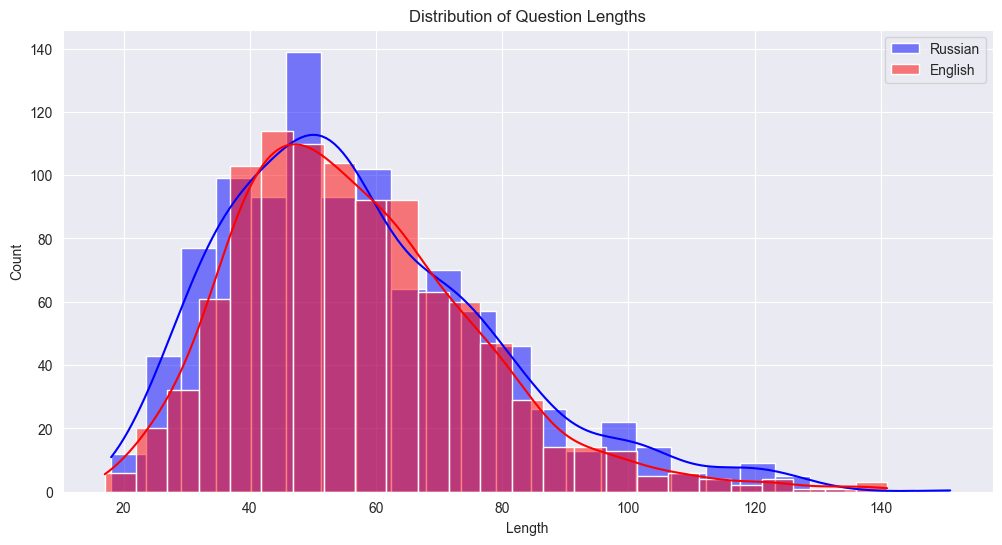

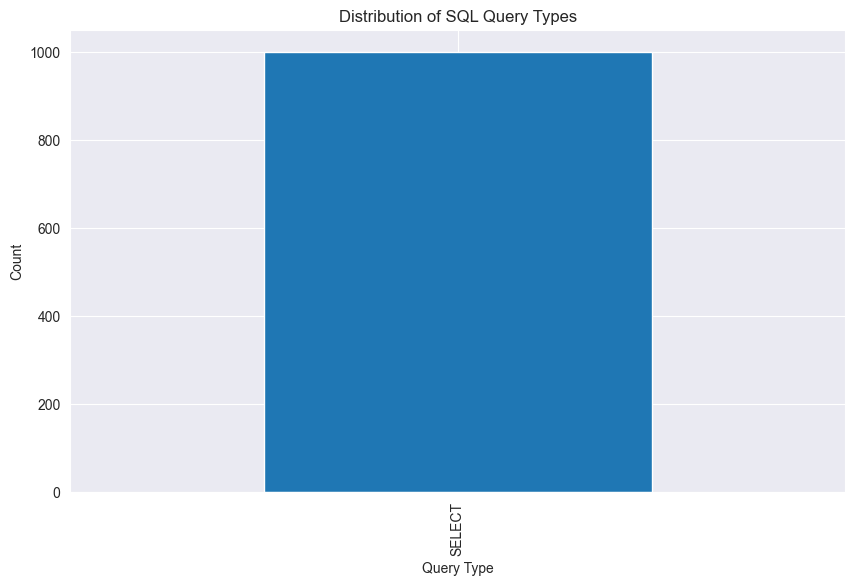

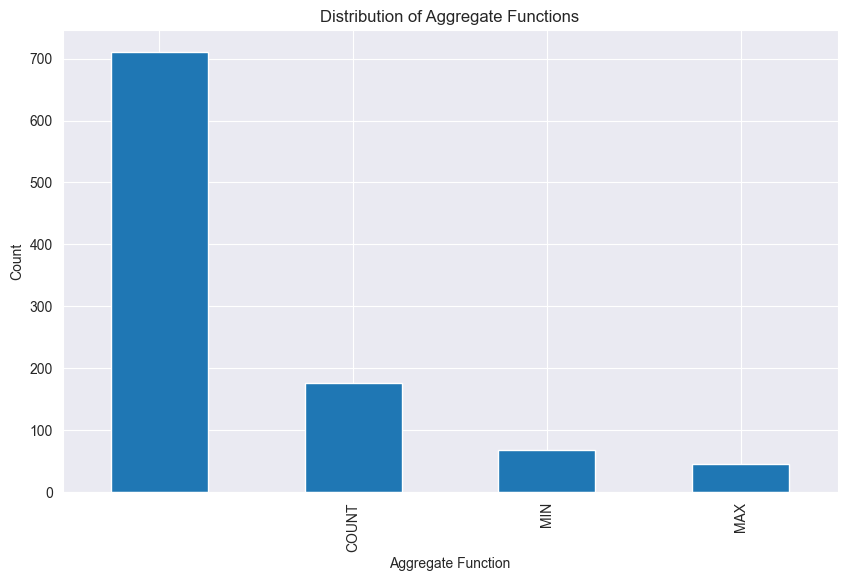

             sel         agg  question_ru_length  question_en_length
count  1000.0000  1000.00000         1000.000000         1000.000000
mean      2.9900     0.71000           57.224000           56.753000
std       2.2228     1.18292           21.570144           19.401609
min       0.0000     0.00000           18.000000           17.000000
25%       1.0000     0.00000           41.750000           43.000000
50%       3.0000     0.00000           54.000000           54.000000
75%       4.0000     1.00000           70.000000           68.000000
max      10.0000     3.00000          151.000000          141.000000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df['question_ru_length'] = df['question_ru'].str.len()
df['question_en_length'] = df['question_en'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='question_ru_length', kde=True, color='blue', label='Russian')
sns.histplot(data=df, x='question_en_length', kde=True, color='red', label='English')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length')
plt.legend()
plt.show()

df['query_type'] = df['sql_query'].apply(lambda x: x.split()[0])
plt.figure(figsize=(10, 6))
df['query_type'].value_counts().plot(kind='bar')
plt.title('Distribution of SQL Query Types')
plt.xlabel('Query Type')
plt.ylabel('Count')
plt.show()

agg_funcs = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]
df['agg_func'] = df['agg'].map(lambda x: agg_funcs[x] if x < len(agg_funcs) else "UNKNOWN")
plt.figure(figsize=(10, 6))
df['agg_func'].value_counts().plot(kind='bar')
plt.title('Distribution of Aggregate Functions')
plt.xlabel('Aggregate Function')
plt.ylabel('Count')
plt.show()

print(df.describe())

*7. Text Preprocessing*
The preprocess_text function performs text cleaning and tokenization for Russian text, removing stop words. This step is necessary for preparing the text for vectorization.

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['question_ru_processed'] = df['question_ru'].apply(preprocess_text)

print(df[['question_ru', 'question_ru_processed']].head())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                               question_ru_processed  
0        расскажите какие примечания южной австралии  
1              текущий сериал начался июне 2011 года  
2                             формат южной австралии  
3  назовите цвет фона австралийской столичной тер...  
4  сколько топливо двигателей сжатым природным газом  


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/a.getashvili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a.getashvili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*8. Splitting Data*
Data is split into training and testing sets using train_test_split, allowing the model to be trained on one part of the data and evaluated on another.

In [9]:
from sklearn.model_selection import train_test_split

X = df['question_ru_processed']
y = df['sql_query']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 800
Test set size: 200


*9. Vectorizing Text*
Texts are transformed into numerical vectors using TfidfVectorizer, which is required for machine learning model training.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

*10. Training Logistic Regression*
A logistic regression model is trained on the vectorized data. This model is used for an initial assessment of classification performance.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(multi_class='ovr', max_iter=1000)
model.fit(X_train_vectorized, y_train)

y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


                                                                                                              precision    recall  f1-score   support

      SELECT COUNT(column1) FROM table_name WHERE column10 = 'BGS' AND column8 = 'ACGS' AND column2 = 'ACGS'       0.00      0.00      0.00       1.0
                                   SELECT COUNT(column1) FROM table_name WHERE column2 = '"Conference Call"'       0.00      0.00      0.00       1.0
                         SELECT COUNT(column1) FROM table_name WHERE column2 = 'Bosch Spark Plug Grand Prix'       0.00      0.00      0.00       1.0
                                   SELECT COUNT(column1) FROM table_name WHERE column2 = 'Natalia Raskokoha'       0.00      0.00      0.00       1.0
                                               SELECT COUNT(column1) FROM table_name WHERE column3 = '17.72'       0.00      0.00      0.00       1.0
                                            SELECT COUNT(column1) FROM table_name WHERE column5 = '

/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

*11. Training Data Information*
Information about the classes in the training set is displayed to ensure that the data is balanced.

In [12]:
print(y_train.nunique())
print(y_train.value_counts())

782
sql_query
SELECT MIN(column2) FROM table_name                                   4
SELECT MAX(column2) FROM table_name                                   3
SELECT column8 FROM table_name WHERE column3 = '2R'                   2
SELECT column3 FROM table_name WHERE column2 = 'French Grand Prix'    2
SELECT column7 FROM table_name WHERE column5 = 'Jim Pugh'             2
                                                                     ..
SELECT column3 FROM table_name WHERE column1 = '2053'                 1
SELECT column1 FROM table_name WHERE column5 = 'D5244 T7'             1
SELECT column5 FROM table_name WHERE column2 = 'Zeltweg Airfield'     1
SELECT column6 FROM table_name WHERE column4 = 'Mike Hawthorn'        1
SELECT column5 FROM table_name WHERE column1 = 12                     1
Name: count, Length: 782, dtype: int64


*12. Extracting SQL Components*
The extract_components function splits SQL queries into parts, such as SELECT and WHERE. This allows for additional analysis at the component level.

In [13]:
def extract_components(sql):
    select = sql.split('FROM')[0].strip()
    where = sql.split('WHERE')[-1].strip() if 'WHERE' in sql else ''
    return select, where

df['select'], df['where'] = zip(*df['sql_query'].apply(extract_components))

*13. Training Random Forest*
A random forest model is trained on the same vectorized data as the logistic regression model. This can help improve prediction quality with a more complex model.

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=42)

*14. Classifying SQL Queries*
The categorize_sql function classifies SQL queries by type. A new column in the DataFrame is created with these categories, and the data is split again.

In [15]:
from sklearn.preprocessing import LabelEncoder

def categorize_sql(query):
    if 'SELECT' in query and 'WHERE' in query:
        return 'SELECT_WITH_WHERE'
    elif 'SELECT' in query:
        return 'SELECT_ONLY'
    else:
        return 'OTHER'

df['sql_category'] = df['sql_query'].apply(categorize_sql)

le = LabelEncoder()
y = le.fit_transform(df['sql_category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*15. Data Augmentation*
Introduce variations to the text data using noise and back translation to make the model more robust.

In [16]:
import numpy as np

def add_noise(text, noise_level=0.1):
    chars = list(text)
    num_noisy_chars = int(len(chars) * noise_level)
    indices = np.random.choice(len(chars), num_noisy_chars, replace=False)
    
    for index in indices:
        chars[index] = np.random.choice(list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"))
    
    return ''.join(chars)

In [17]:
def back_translate_text(text, intermediate_language='fr'):
    translated_text = GoogleTranslator(source='auto', target=intermediate_language).translate(text)
    back_translated_text = GoogleTranslator(source=intermediate_language, target='ru').translate(translated_text)
    return back_translated_text

*16. Data Preparation*
Apply the augmentation techniques to the text data and split it into training and testing sets.

In [18]:
noise_level = 0.1

df['question_ru_noisy'] = df['question_ru'].apply(lambda x: add_noise(x, noise_level))
print(df[['question_ru', 'question_ru_noisy']].head())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                                   question_ru_noisy  
0  Расскажитеrмне, какие есть примечания д1я Южно...  
1     К8койhтекущий сериал на1ался в июне 2311 года?  
2                  Какой формnA для Южной АвстралDи?  
3  Назовите цвет фонd длy АRстралийGкой столичной...  
4  Сколь3U раз т3пливо длz двигател6й было сжатым...  


In [19]:
df['question_ru_back_translated'] = df['question_ru'].apply(back_translate_text)
print(df[['question_ru', 'question_ru_back_translated']].head())

                                         question_ru  \
0  Расскажите мне, какие есть примечания для Южно...   
1     Какой текущий сериал начался в июне 2011 года?   
2                  Какой формат для Южной Австралии?   
3  Назовите цвет фона для Австралийской столичной...   
4  Сколько раз топливо для двигателей было сжатым...   

                         question_ru_back_translated  
0     Скажите мне, какие рейтинги у Южной Австралии?  
1   Какой текущий сериал стартовал в июне 2011 года?  
2                      Каков формат Южной Австралии?  
3  Назовите цвет фона австралийской столичной тер...  
4  Сколько раз моторное топливо представляло собо...  


*17. Vectorization*
Convert the augmented text data into numerical features using vectorization techniques.

In [20]:
X_noisy = df['question_ru_noisy']

X_train_noisy, X_test_noisy, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

print(f"Training set size (noisy): {len(X_train_noisy)}")
print(f"Test set size (noisy): {len(X_test_noisy)}")

vectorizer_noisy = TfidfVectorizer(max_features=5000)
X_train_noisy_vectorized = vectorizer_noisy.fit_transform(X_train_noisy)
X_test_noisy_vectorized = vectorizer_noisy.transform(X_test_noisy)

Training set size (noisy): 800
Test set size (noisy): 200


In [21]:
X_back_translated = df['question_ru_back_translated']

X_train_back_translated, X_test_back_translated, y_train, y_test = train_test_split(X_back_translated, y, test_size=0.2, random_state=42)

print(f"Training set size (back-translated): {len(X_train_back_translated)}")
print(f"Test set size (back-translated): {len(X_test_back_translated)}")

vectorizer_back_translated = TfidfVectorizer(max_features=5000)
X_train_back_translated_vectorized = vectorizer_back_translated.fit_transform(X_train_back_translated)
X_test_back_translated_vectorized = vectorizer_back_translated.transform(X_test_back_translated)

Training set size (back-translated): 800
Test set size (back-translated): 200


*18. Model Training*
Train different machine learning models on the vectorized data, including logistic regression and neural networks, with and without data augmentation.

In [22]:
from sklearn.metrics import log_loss, accuracy_score

def train_logistic_regression_with_history(X_train, y_train, X_val, y_val, max_iter=1000):
    model = LogisticRegression(multi_class='ovr', max_iter=1, warm_start=True)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for _ in range(max_iter):
        model.fit(X_train, y_train)
        
        y_train_pred_proba = model.predict_proba(X_train)
        y_train_pred = model.predict(X_train)
        
        y_val_pred_proba = model.predict_proba(X_val)
        y_val_pred = model.predict(X_val)
        
        history['loss'].append(log_loss(y_train, y_train_pred_proba))
        history['accuracy'].append(accuracy_score(y_train, y_train_pred))
        history['val_loss'].append(log_loss(y_val, y_val_pred_proba))
        history['val_accuracy'].append(accuracy_score(y_val, y_val_pred))
    
    return model, history

In [23]:
from keras.src.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.src.optimizers import Adam
from keras.src.layers import Dense, Dropout
from keras import Sequential

num_classes = len(set(y))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_no_augmentation = model.fit(X_train_dense, y_train, epochs=50, batch_size=32, 
                                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7135 - loss: 0.9336 - val_accuracy: 0.9937 - val_loss: 0.6530
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9699 - loss: 0.5655 - val_accuracy: 0.9937 - val_loss: 0.2855
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9640 - loss: 0.2851 - val_accuracy: 0.9937 - val_loss: 0.1547
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9666 - loss: 0.2176 - val_accuracy: 0.9937 - val_loss: 0.1339
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9759 - loss: 0.1656 - val_accuracy: 0.9937 - val_loss: 0.1227
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9754 - loss: 0.1477 - val_accuracy: 0.9937 - val_loss: 0.1138
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9764 - loss: 0.1226 - val_accuracy: 0.9937 - val_loss: 0.1018
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.1318 - val_accuracy: 0.9937 - val_loss: 0.0957
Epo

In [24]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

num_classes = len(set(y_train))

model_noisy = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_noisy_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model_noisy.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_noisy_dense = X_train_noisy_vectorized.toarray()
X_test_noisy_dense = X_test_noisy_vectorized.toarray()

early_stopping_noisy = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_noisy = model_noisy.fit(X_train_noisy_dense, y_train, epochs=50, batch_size=32,
                                validation_split=0.2, callbacks=[early_stopping_noisy], class_weight=class_weight_dict)

y_pred_noisy_probs = model_noisy.predict(X_test_noisy_dense)

y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

print("Classification report for noisy data:")
print(classification_report(y_test, y_pred_noisy))

Epoch 1/50


/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4292 - loss: 1.0856 - val_accuracy: 0.5437 - val_loss: 0.8134
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7197 - loss: 0.7708 - val_accuracy: 0.7188 - val_loss: 0.7655
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.7625 - val_accuracy: 0.4938 - val_loss: 0.7658
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.6678 - val_accuracy: 0.7500 - val_loss: 0.7159
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.6325 - val_accuracy: 0.8750 - val_loss: 0.5823
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9884 - loss: 0.5806 - val_accuracy: 0.7563 - val_loss: 0.6129
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3508 - val_accuracy: 0.8438 - val_loss: 0.4882
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.3005 - val_accuracy: 0.8125 - val_loss: 0.5114
Epo

In [25]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model_back_translated = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_back_translated_vectorized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

model_back_translated.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_back_translated_dense = X_train_back_translated_vectorized.toarray()
X_test_back_translated_dense = X_test_back_translated_vectorized.toarray()

early_stopping_back_translation = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_back_translation = model_back_translated.fit(X_train_back_translated_dense, y_train, epochs=50, batch_size=32,
                                                     validation_split=0.2, callbacks=[early_stopping_back_translation], class_weight=class_weight_dict)


y_pred_back_translated = model_back_translated.predict(X_test_back_translated_dense)
y_pred_back_translated_classes = np.argmax(y_pred_back_translated, axis=1)

print("Classification report for back-translated data:")
print(classification_report(y_test, y_pred_back_translated_classes))

Epoch 1/50


/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8334 - loss: 0.8999 - val_accuracy: 0.9937 - val_loss: 0.7652
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9476 - loss: 1.0473 - val_accuracy: 0.9937 - val_loss: 0.7163
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9652 - loss: 0.7262 - val_accuracy: 0.9937 - val_loss: 0.6422
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - loss: 0.8680 - val_accuracy: 0.9812 - val_loss: 0.5635
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.6508 - val_accuracy: 0.9750 - val_loss: 0.4815
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.5277 - val_accuracy: 0.9563 - val_loss: 0.4105
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.4336 - val_accuracy: 0.9375 - val_loss: 0.3664
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.2965 - val_accuracy: 0.9312 - val_loss: 0.3352
Epo

*19. Model Evaluation*
Evaluate the performance of the trained models using various metrics and visualizations to assess their effectiveness.

In [26]:
import numpy as np

train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

print("Training class distribution:")
for cls, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"Class {cls}: {count} samples")

print("\nTesting class distribution:")
for cls, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"Class {cls}: {count} samples")

Training class distribution:
Class 0: 21 samples
Class 1: 779 samples

Testing class distribution:
Class 0: 4 samples
Class 1: 196 samples


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

predictions = model.predict(X_test_dense)
predicted_categories = le.inverse_transform(predictions.argmax(axis=1))

print(confusion_matrix(le.inverse_transform(y_test), predicted_categories))
print(classification_report(le.inverse_transform(y_test), predicted_categories))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.3005 - val_accuracy: 0.9937 - val_loss: 0.0662
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.1873 - val_accuracy: 0.9937 - val_loss: 0.0627
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.1453 - val_accuracy: 0.9937 - val_loss: 0.0680
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.1759 - val_accuracy: 0.9937 - val_loss: 0.0723
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1057 - val_accuracy: 0.9937 - val_loss: 0.0708
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1753 - val_accuracy: 0.9937 - val_loss: 0.0692
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1336 - val_accuracy: 0.9937 - val_loss: 0.0701
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0946 - val_accuracy: 0.9937 - val_loss:

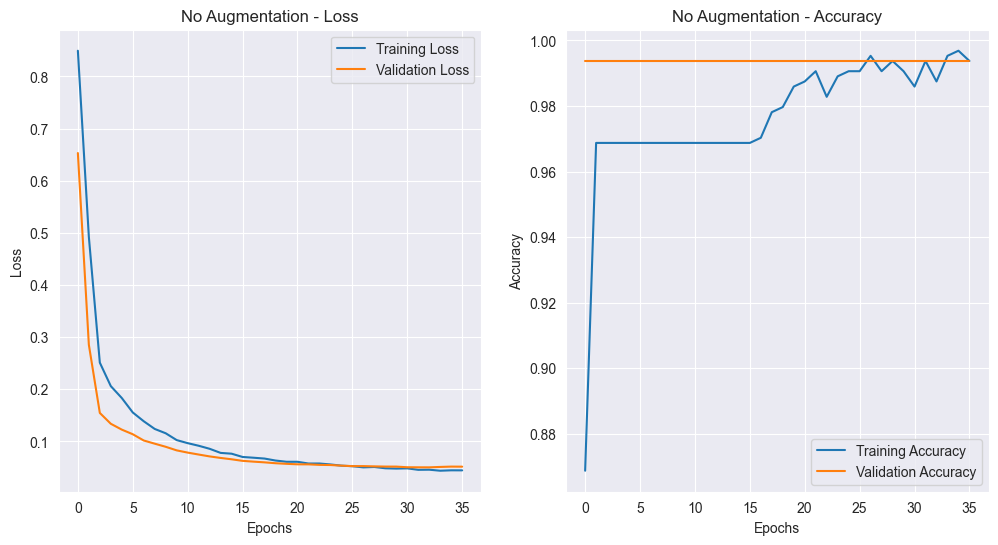

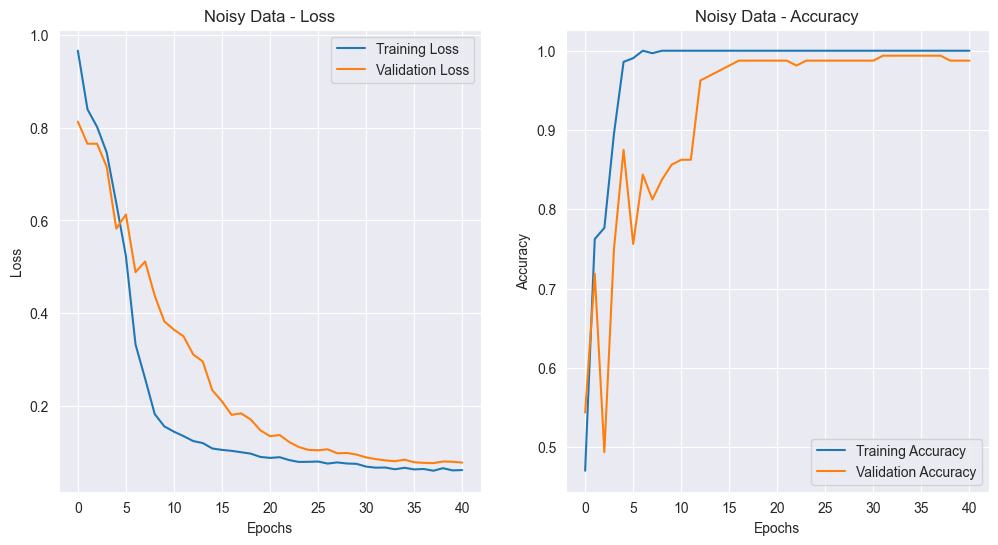

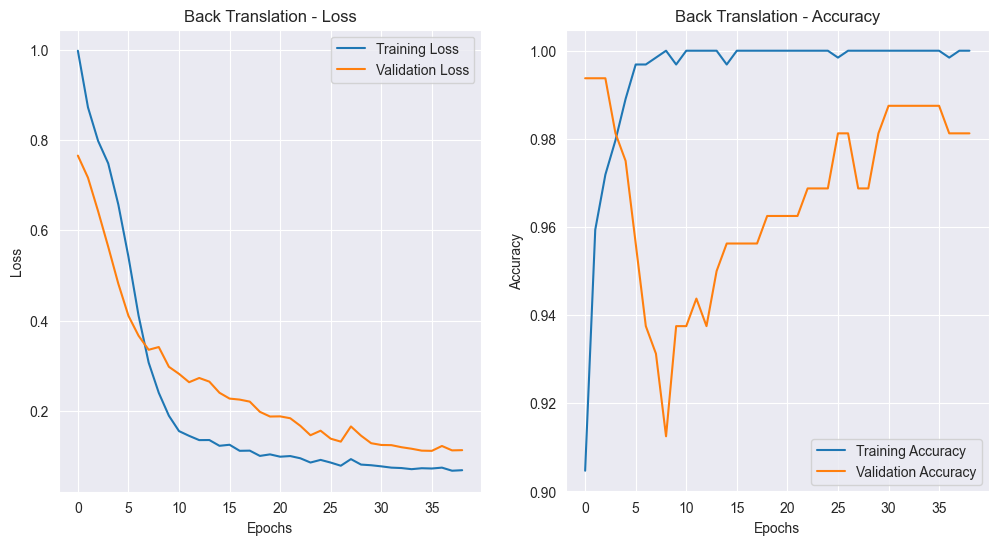

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))

    if isinstance(history, dict):
        loss = history['loss']
        val_loss = history['val_loss']
        accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']
    else:
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
    
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


plot_training_history(history_no_augmentation, "No Augmentation")
plot_training_history(history_noisy, "Noisy Data")
plot_training_history(history_back_translation, "Back Translation")

1. No Augmentation:
Training/Validation Loss: The loss consistently decreases for both training and validation, indicating effective learning without overfitting. The curves converge, suggesting good generalization to the validation data.
Training/Validation Accuracy: Both accuracy curves steadily increase and converge at a high value (~0.99), reflecting strong model performance on both training and validation datasets.

2. Noisy Data:
Training/Validation Loss: The training loss decreases consistently, while the validation loss fluctuates more, particularly during the early epochs, before eventually stabilizing. This indicates initial difficulties in generalizing to noisy data, but the model adjusts over time.
Training/Validation Accuracy: The training accuracy quickly reaches near-perfect levels, while the validation accuracy shows significant fluctuations early on, eventually stabilizing as the model adapts to the noise.

3. Back Translation:
Training/Validation Loss: Both losses decrease, but the validation loss diverges significantly from the training loss after the initial epochs, suggesting challenges in generalizing well with this augmentation technique.
Training/Validation Accuracy: The validation accuracy shows considerable fluctuations, indicating inconsistent performance on unseen data when using back translation, despite high training accuracy.